#### Resources:
- https://ax.dev/docs/core.html#trial-vs-batched-trial
- https://ax.dev/docs/trial-evaluation.html
- https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
- https://ax.dev/tutorials/gpei_hartmann_service.html
- https://ax.dev/tutorials/multiobjective_optimization.html
- Offline optimization tutotial: https://www.youtube.com/watch?v=Wyeab_JNBAo
- For more info on qNEHVI and noisy Bayes-Opt in general, see attached papers (e.g. Monte Carlo acquisition function etc.).
- https://botorch.org/docs/models --> See All Models (use Single-Task GPs here) + Noise Explanation

### How to cite Ax:

AE: A domain-agnostic platform for adaptive experimentation.
Eytan Bakshy, Lili Dworkin, Brian Karrer, Konstantin Kashin, Ben Letham, Ashwin Murthy, Shaun Singh. NeurIPS Systems for ML Workshop, 2018

OR: ==============================

@Article{balandat2019botorch,
  Author = {Balandat, Maximilian and Karrer, Brian and Jiang, Daniel R. and Daulton, Samuel and Letham, Benjamin and Wilson, Andrew Gordon and Bakshy, Eytan},
  Journal = {arxiv e-prints},
  Title = {{BoTorch: A Framework for Efficient Monte-Carlo Bayesian Optimization}},
  Year = {2019},
  url = {https://arxiv.org/abs/1910.06403}
}

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ax
# import botorch
# import gpytorch

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

# New function based on Monte Carlo Acq. Function:
# qNEHVI better than SOBOL and PAREGO for MOO - exploring tradeoff space & GPEI is only single-objective = see Tutorials +
"""These are different use cases - qNEHVI will explore the Pareto frontier and try to find optimal tradeoffs between your 
objectives. GPEI on the other hand optimizes a single objective (possibly subject to a constraint on the other objective 
if you specify that). If you know exactly what kind of constraint you can tolerate or how to weight your two objectives, 
GPEI will be more sample efficient, but if you try to explore the set of optimal tradeoffs you should use qNEHVI."""

# For batch optimization (or in noisy settings), we strongly recommend using qNEHVI rather than qEHVI because it is 
# far more efficient than qEHVI and mathematically equivalent in the noiseless setting.
# Models.MOO already uses qNEHVI by default.

#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------

from ax.modelbridge.factory import get_MOO_NEHVI
"""NOTE: Model can be specified either from the model registry (ax.modelbridge.registry.Models 
or using a callable model constructor [function]. 
ONLY MODELS FROM THE REGISTRY CAN BE SAVED, and thus optimization can only be resumed if interrupted when using models from the registry."""

# So I will use the registry as I want to save the model and resume optimization at a later time

# CAN'T BE SAVED:
# Similarly, set custom acquisition function, varying defaults - https://ax.dev/tutorials/modular_botax.html
# model = ax.modelbridge.registry.Models.BOTORCH_MODULAR,
# e.g. after max_parallelism:

"""            model_kwargs={        
                "surrogate_specs":
                {
                    "surrogate": ax.models.torch.botorch_modular.model.SurrogateSpec( 
                        botorch_model_class=botorch.models.gp_regression.SingleTaskGP, 
                        # SingleTaskGP: a single-task exact GP that infers a homoskedastic noise level (no noise observations).
                        covar_module_class=gpytorch.kernels.MaternKernel 
                        # covar_module_class=gpytorch.kernels.RBFKernel

                        # gp_kernel – kernel name. Currently only two kernels are supported: “matern” for Matern Kernel and “rbf” for RBFKernel. 
                        # Defaults to “matern”.

                        # The class of Matern kernels is a generalization of the RBF . It has an additional parameter which controls the smoothness of the resulting function. 
                        # The smaller , the less smooth the approximated function is. As ν → ∞ , the kernel becomes equivalent to the RBF kernel.
                        # from: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html
                        
                                                                                    )
                },
                "botorch_acqf_class": botorch.acquisition.monte_carlo.qNoisyExpectedImprovement # qNEHVI
"""
# UCB is another option, but again needs BOTORCH_MODULAR which can't be saved

C:\Users\lordm\AppData\Local\Temp\ipykernel_2808\3884563701.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


'            model_kwargs={        \n                "surrogate_specs":\n                {\n                    "surrogate": ax.models.torch.botorch_modular.model.SurrogateSpec( \n                        botorch_model_class=botorch.models.gp_regression.SingleTaskGP, \n                        # SingleTaskGP: a single-task exact GP that infers a homoskedastic noise level (no noise observations).\n                        covar_module_class=gpytorch.kernels.MaternKernel \n                        # covar_module_class=gpytorch.kernels.RBFKernel\n\n                        # gp_kernel – kernel name. Currently only two kernels are supported: “matern” for Matern Kernel and “rbf” for RBFKernel. \n                        # Defaults to “matern”.\n\n                        # The class of Matern kernels is a generalization of the RBF . It has an additional parameter which controls the smoothness of the resulting function. \n                        # The smaller , the less smooth the approximated func

### Training data and Parameters

In [2]:
unique_parameters = ["tungstate_concentration", "current_density", "deposition_time", "pH"] 
# temperature avoided, kept constant at 25 C

# EXAMPLE, here use actual data
X_train = np.array([[0.05, 10, 500, 5],
               [0.05, 50, 300, 6],
               [0.1, 10, 300, 7],
               [0.1, 10, 600, 8],
               
               [0.1, 50, 600, 7.5],
               [0.1, 100, 600, 10],
               [0.1, 50, 400, 6.5],
               [0.1, 30, 600, 8.5],
               [0.15, 10, 600, 9.5],
               [0.15, 50, 300, 9.5],
               
               # NEW OPTIMIZATION DATA

        
               
               ])

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=unique_parameters)
X_train

tungstate_concentration  current_density  deposition_time    pH
0                     0.05             10.0            500.0   5.0
1                     0.05             50.0            300.0   6.0
2                     0.10             10.0            300.0   7.0
3                     0.10             10.0            600.0   8.0
4                     0.10             50.0            600.0   7.5
5                     0.10            100.0            600.0  10.0
6                     0.10             50.0            400.0   6.5
7                     0.10             30.0            600.0   8.5
8                     0.15             10.0            600.0   9.5
9                     0.15             50.0            300.0   9.5

In [3]:
# Number of data points
n_train = X_train.shape[0]

unique_objectives = ["overpotential", "overpotential_slope"]

# EXAMPLE, here use actual observations
y_train = np.array([[-358,0.00015], 
                    [-319,0.000066], 
                    [-377,0.0001], 
                    [-319,-0.000518],
                    [-286,0.00008], 
                    [-312,0.000029], 
                    [-309,-0.000057], 
                    [-290,0.001656],
                    [-329,0.000131], 
                    [-305,-0.000064],

                    # NEW OPTIMIZATION DATA


                    
                    ])

# Convert to dataframe
y_train = pd.DataFrame(y_train, columns=unique_objectives)
y_train

overpotential  overpotential_slope
0         -358.0             0.000150
1         -319.0             0.000066
2         -377.0             0.000100
3         -319.0            -0.000518
4         -286.0             0.000080
5         -312.0             0.000029
6         -309.0            -0.000057
7         -290.0             0.001656
8         -329.0             0.000131
9         -305.0            -0.000064

Keep choice parameters or expand domain space to RANGE (feature not yet implemented)

- Will allow us to visualize w/ contour plots (response surface) e.g. 
- Check how good the model is for both cases + trial recommendations

Orthogonal to that, another challenge may be the choice parameters. There is a know issue with our optimization strategy that can result in excessive repeated evaluations of the same choice values. 
--> Happens Here As Well!

Expanding the domain/search space to include in-between values i.e. Range Parameters:

In [3]:
parameters=[
        {
            "name": "tungstate_concentration",
            "type": "range",
            "bounds": [0.05, 0.2],
        },
        {
            "name": "current_density",
            "type": "range",
            "bounds": [5, 125],
        },
        {
            "name": "deposition_time",
            "type": "range",
            "bounds": [60, 600],
        },
        {
            "name": "pH",
            "type": "range",
            "bounds": [5, 10],
        }
        ]

### Generation Strategy

In [4]:
# Specify a custom generation strategy - Skips the pseudo-random initial suggested points 
gs = GenerationStrategy(
    steps=[
        # Try quasi-random Sobol sequence along with my initial data
        # GenerationStep(
            # model=Models.SOBOL, 
            # num_trials=5,  # How many trials to produce during generation step
            # min_trials_observed=3,  # How many trials to be completed before next model
            # max_parallelism=5  # Max parallelism for this step
        # ),
        ################
        # Skips SOBOL sampling step (which is the default first step) and uses the initial data provided
        # Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model = Models.MOO,
            # Uses qNEHVI by default, use instead of GPEI (for single) and PAREGO (for multi but worse than qNEHVI)
            # Not passing any information about the observation noise; so the model is inferring a Gaussian noise level on the observations - SingleTaskGP
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3  # BATCH/Parallelism limit for this step, often lower than for Sobol
                    )
            ]
)

### Setup the experiment

In [5]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="NiW",
    parameters=parameters,
    objectives={
        # ON THRESHOLDS: 
        # Optional float representing the smallest objective value (respectively largest if minimize=True) that is considered valuable in the context of multi-objective optimization. 
        # In BoTorch and in the literature, this is also known as an element of the reference point vector that defines the hyper-volume of the Pareto front.

        # Optional, will be inferred if not set manually, they help us make use of domain knowledge.
        # Basically only the points within the thresholds will be considered as for the Pareto frontier and objective improvement.

        # Ax will ALWAYS try to find points that optimize objectives BEYOND the specified thresholds, using all available data.
        # Lower bound if maximizing --> it searches and considers optimum points ABOVE threshold
        
        # Set LOWER thresholds if Ax is unable to find any Pareto optimal points with your current data and thresholds. 
        # This gives it more feasible goals.
        # Set HIGHER thresholds if you are getting Pareto optimal results but want to push further. 
        # This sets tougher goals for optimization.

        # ====================================================================================================
        
        # From Balandat:
        
        # The (threshold) reference point should be set to be slightly WORSE (10% is reasonable) than the worst value of each objective 
        # that a decision maker would tolerate. These can be chosen by asking the following question for each of your objectives: 
        
        # For objective A, if all other objectives had amazing values, what is the worst allowable/viable value for
        # objective A from an application standpoint? Phrased conversely, what value of objective A would make the material 
        # inviable in spite of great performance for the other objectives? 
        
        # Then give yourself something like a 10% tolerance on this outcome. For example, if you're MINIMIZING objective A, 
        # and the maximum allowable value is 1.0, then set the outcome constraint to something like yA<= 1.0/0.9=1.11.

        # RESPECTIVELY: If MAXIMIZING, and minimum allowable value is -350, then set the outcome constraint to:
        # yA>= -350 + 0.1*(-350) = -350 - 35 = -385

        "overpotential": ObjectiveProperties(minimize=False, threshold = -350), # How ambitious + what is max (min) allowable value?
        "overpotential_slope": ObjectiveProperties(minimize=False, threshold = -0.001) # Not clear, looking for >=0 if possible

        # On SEM:
        # Result of the evaluation should generally be a mapping of the format: {metric_name -> (mean, SEM)}. 
        # It can also return only the mean as a float, in which case Ax will treat SEM as unknown and use a model that can INFER it.
    },
    overwrite_existing_experiment=False, # I am saving my data anyway, but just to make sure
    is_test = False, # Set this to False when running a REAL experiment
    choose_generation_strategy_kwargs = {"max_parallelism_override": 3} # Parallel/batch evaluation, max batch size set to 3
)

[INFO 02-01 19:58:10] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-01 19:58:10] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter tungstate_concentration. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-01 19:58:10] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter current_density. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-01 19:58:10] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter deposition_time. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

### A note on parallelism:

Tradeoff between parallelism and total number of trials
In Bayesian Optimization (any optimization, really), we have the choice between performing evaluations of our function in a sequential fashion (i.e. only generate a new candidate point to evaluate after the previous candidate has been evaluated), or in a parallel fashion (where we evaluate multiple candidates concurrently). The sequential approach will (in expectation) produce better optimization results, since at any point during the optimization the ML model that drives it uses strictly more information than the parallel approach. However, if function evaluations take a long time and end-to-end optimization time is important, then the parallel approach becomes attractive. The difference between the performance of a sequential (aka 'fully adaptive') algorithm and that of a (partially) parallelized algorithm is referred to as the 'adaptivity gap'.

To balance end-to-end optimization time with finding the optimal solution in fewer trials, we opt for a ‘staggered’ approach by allowing a limited number of trials to be evaluated in parallel. By default, in simplified Ax APIs (e.g., in Service API) the allowed parallelism for the Bayesian phase of the optimization is 3. Service API tutorial has more information on how to handle and change allowed parallelism for that API.

### Input training data (run this only the FIRST TIME, manually write ALL data down too)

Here we're using a dictionary comprehension to iterate through the parameters and values in each row of the X_train DataFrame. For parameters that are "current_density," "deposition_time," or "temperature," we convert the value to an integer using int(value), and for the "tungstate_concentration" parameter, we convert the value to a float using float(value). This ensures that the values match the respective parameter types in the Ax experiment.

We need to do this because our search space consists of 'Choice' Parameters. - ISSUE NOT FIXED YET, under development

In [8]:
# Initialize trial index - MANUALLY to avoid weird errors
trial_index = 0

# Attach the training data
for i in range(n_train):
    trial_parameters = {
        param: int(value) if param in ["current_density", "deposition_time", "pH"] else float(value)
        for param, value in X_train.iloc[i, :].items()
    }
    
    # Create a dictionary with the raw data for each objective
    trial_raw_data = {obj: float(value) for obj, value in zip(unique_objectives, y_train.iloc[i])}
    
    # Attach trial and complete it
    ax_client.attach_trial(trial_parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=trial_raw_data)
    
    # Increment trial index
    trial_index += 1

[INFO 09-27 23:33:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 10, 'deposition_time': 500, 'pH': 5}] as trial 0.
[INFO 09-27 23:33:09] ax.service.ax_client: Completed trial 0 with data: {'overpotential': (-358.0, None), 'overpotential_slope': (0.00015, None)}.
[INFO 09-27 23:33:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 300, 'pH': 6}] as trial 1.
[INFO 09-27 23:33:09] ax.service.ax_client: Completed trial 1 with data: {'overpotential': (-319.0, None), 'overpotential_slope': (6.6e-05, None)}.
[INFO 09-27 23:33:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.1, 'current_density': 10, 'deposition_time': 300, 'pH': 7}] as trial 2.
[INFO 09-27 23:33:09] ax.service.ax_client: Completed trial 2 with data: {'overpotential': (-377.0, None), 'overpotential_slope': (0.0001, None)}.
[INFO 09-27 23:33:

### Run optimization and get next suggestions

In [9]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 09-27 23:33:14] ax.service.ax_client: Generated new trial 10 with parameters {'tungstate_concentration': 0.098355, 'current_density': 48, 'deposition_time': 600, 'pH': 9}.
[INFO 09-27 23:33:14] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.09835481238803137, 'current_density': 48, 'deposition_time': 600, 'pH': 9}


[INFO 09-27 23:33:15] ax.service.ax_client: Generated new trial 11 with parameters {'tungstate_concentration': 0.142025, 'current_density': 52, 'deposition_time': 600, 'pH': 8}.
[INFO 09-27 23:33:15] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.14202503390127522, 'current_density': 52, 'deposition_time': 600, 'pH': 8}


[INFO 09-27 23:33:17] ax.service.ax_client: Generated new trial 12 with parameters {'tungstate_concentration': 0.067493, 'current_density': 47, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.06749297114643009, 'current_density': 47, 'deposition_time': 600, 'pH': 8}


It suggests three new trials (trial 10, 11, and 12), and for the first two, I'm getting the message: 

"The observations are identical to the last set of observations used to fit the model. Skipping model fitting." 

This means that the model has determined that the data observed for these trials is very similar to the existing data used to train the model. Therefore, there's little to gain from refitting the model with nearly identical data. For the third trial (trial 12), it doesn't display the message, indicating that the data for this trial might be more informative or different enough to warrant retraining the model.

- **Basically the first 2 recommendations are quite similar to each other, when looking at the proposed parameters, so the model doesn't need to be retrained. The third one is different enough to warrant retraining the model.**

In [10]:
ax_client.generation_strategy.trials_as_df

[INFO 09-27 23:33:24] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0                0              MOO           10      RUNNING   
1                0              MOO           11      RUNNING   
2                0              MOO           12      RUNNING   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.14, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.07, 'cu...

### Perform lab experiments and get new objectives

#### Complete pending trials
 We manually set SEM = None to indicate that we know the function to be noisy, but would like Ax to estimate the noise for us.

In [11]:
ax_client.complete_trial(trial_index=10, raw_data={'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)})

[INFO 09-27 23:33:25] ax.service.ax_client: Completed trial 10 with data: {'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)}.


In [12]:
ax_client.complete_trial(trial_index=11, raw_data={'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)})
ax_client.complete_trial(trial_index=12, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)})

[INFO 09-27 23:33:26] ax.service.ax_client: Completed trial 11 with data: {'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)}.
[INFO 09-27 23:33:26] ax.service.ax_client: Completed trial 12 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)}.


In [13]:
ax_client.generation_strategy.trials_as_df

[INFO 09-27 23:33:27] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0                0              MOO           10    COMPLETED   
1                0              MOO           11    COMPLETED   
2                0              MOO           12    COMPLETED   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.14, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.07, 'cu...

#### Etc.

In [14]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 09-27 23:33:30] ax.service.ax_client: Generated new trial 13 with parameters {'tungstate_concentration': 0.079193, 'current_density': 55, 'deposition_time': 480, 'pH': 8}.
[INFO 09-27 23:33:30] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.07919348817916194, 'current_density': 55, 'deposition_time': 480, 'pH': 8}


[INFO 09-27 23:33:32] ax.service.ax_client: Generated new trial 14 with parameters {'tungstate_concentration': 0.05, 'current_density': 63, 'deposition_time': 600, 'pH': 8}.
[INFO 09-27 23:33:32] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.05, 'current_density': 63, 'deposition_time': 600, 'pH': 8}


[INFO 09-27 23:33:33] ax.service.ax_client: Generated new trial 15 with parameters {'tungstate_concentration': 0.05, 'current_density': 52, 'deposition_time': 487, 'pH': 9}.


next suggested experiment:  {'tungstate_concentration': 0.05, 'current_density': 52, 'deposition_time': 487, 'pH': 9}


In [15]:
ax_client.complete_trial(trial_index=13, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=14, raw_data={'overpotential': (-259.0, None), 'overpotential_slope': (+0.00004, None)})
ax_client.complete_trial(trial_index=15, raw_data={'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)})

[INFO 09-27 23:33:35] ax.service.ax_client: Completed trial 13 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 09-27 23:33:35] ax.service.ax_client: Completed trial 14 with data: {'overpotential': (-259.0, None), 'overpotential_slope': (4e-05, None)}.
[INFO 09-27 23:33:35] ax.service.ax_client: Completed trial 15 with data: {'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)}.


In [16]:
ax_client.generation_strategy.trials_as_df

[INFO 09-27 23:33:37] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0                0              MOO           10    COMPLETED   
1                0              MOO           11    COMPLETED   
2                0              MOO           12    COMPLETED   
3                0              MOO           13    COMPLETED   
4                0              MOO           14    COMPLETED   
5                0              MOO           15    COMPLETED   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.14, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.07, 'cu...  
3  {'13_0': {'tungstate_concentration': 0.08, 'cu...  
4  {'14_0': {'tungstate_concentration': 0.05, 'cu...  
5  {'15_0': {'tungstate_concentration': 0.05, 'cu...

In [ ]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

In [ ]:
ax_client.complete_trial(trial_index=16, raw_data={'overpotential': (-277.0, None), 'overpotential_slope': (-0.0012, None)})
ax_client.complete_trial(trial_index=17, raw_data={'overpotential': (-250.0, None), 'overpotential_slope': (+0.0004, None)})
ax_client.complete_trial(trial_index=18, raw_data={'overpotential': (-239.0, None), 'overpotential_slope': (-0.000055, None)})

#### Etc ...

In [ ]:
# Continue with trial 19
ax_client.complete_trial(trial_index=19, raw_data={'overpotential': -200.0, 'overpotential_slope': 0.005})

# Continue with trial 20
ax_client.complete_trial(trial_index=20, raw_data={'overpotential': -180.0, 'overpotential_slope': 0.008})

# Continue with trial 21
ax_client.complete_trial(trial_index=21, raw_data={'overpotential': -150.0, 'overpotential_slope': 0.01})

# Continue with trial 22
ax_client.complete_trial(trial_index=22, raw_data={'overpotential': -120.0, 'overpotential_slope': 0.05})

# Continue with trial 23
ax_client.complete_trial(trial_index=23, raw_data={'overpotential': -110.0, 'overpotential_slope': 0.08})

# Continue with trial 24
ax_client.complete_trial(trial_index=24, raw_data={'overpotential': -105.0, 'overpotential_slope': 0.1})

# Continue with trial 25
ax_client.complete_trial(trial_index=25, raw_data={'overpotential': -102.0, 'overpotential_slope': 0.11})

# Continue with trial 26
ax_client.complete_trial(trial_index=26, raw_data={'overpotential': -101.0, 'overpotential_slope': 0.12})

# Continue with trial 27
ax_client.complete_trial(trial_index=27, raw_data={'overpotential': -100.0, 'overpotential_slope': 0.13})

# Continue with trial 28
ax_client.complete_trial(trial_index=28, raw_data={'overpotential': -99.5, 'overpotential_slope': 0.14})

# Continue with trial 29
ax_client.complete_trial(trial_index=29, raw_data={'overpotential': -99.0, 'overpotential_slope': 0.15})

# Continue with trial 30
ax_client.complete_trial(trial_index=30, raw_data={'overpotential': -98.5, 'overpotential_slope': 0.16})

### Save/Load the experiment

In [17]:
ax_client.save_to_json_file()  # To save the experiment state to disk.

[INFO 09-27 23:33:46] ax.service.ax_client: Saved JSON-serialized state of optimization to `ax_client_snapshot.json`.


In [4]:
ax_client = AxClient.load_from_json_file() # To restore the experiment state from disk.  
# For custom filepath, pass `filepath` argument.

[INFO 09-26 20:45:31] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [18]:
ax_client.generation_strategy.trials_as_df

[INFO 09-27 23:33:48] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0                0              MOO           10    COMPLETED   
1                0              MOO           11    COMPLETED   
2                0              MOO           12    COMPLETED   
3                0              MOO           13    COMPLETED   
4                0              MOO           14    COMPLETED   
5                0              MOO           15    COMPLETED   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.14, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.07, 'cu...  
3  {'13_0': {'tungstate_concentration': 0.08, 'cu...  
4  {'14_0': {'tungstate_concentration': 0.05, 'cu...  
5  {'15_0': {'tungstate_concentration': 0.05, 'cu...

In [ ]:
# For any issues: https://github.com/facebook/Ax/issues/1565

### Confirm model works, already fitted on initial data

In [21]:
# print('model:', ax_client.generation_strategy.model)
# ax_client.fit_model()

[INFO 09-26 20:27:17] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


model: <ax.modelbridge.torch.TorchModelBridge object at 0x000002B7B751A440>


In [19]:
ax_client.experiment.fetch_data().df

arm_name          metric_name        mean  sem  trial_index
0       0_0        overpotential -358.000000  NaN            0
1       0_0  overpotential_slope    0.000150  NaN            0
2       1_0        overpotential -319.000000  NaN            1
3       1_0  overpotential_slope    0.000066  NaN            1
4       2_0        overpotential -377.000000  NaN            2
5       2_0  overpotential_slope    0.000100  NaN            2
6       3_0        overpotential -319.000000  NaN            3
7       3_0  overpotential_slope   -0.000518  NaN            3
8       4_0        overpotential -286.000000  NaN            4
9       4_0  overpotential_slope    0.000080  NaN            4
10      5_0        overpotential -312.000000  NaN            5
11      5_0  overpotential_slope    0.000029  NaN            5
12      6_0        overpotential -309.000000  NaN            6
13      6_0  overpotential_slope   -0.000057  NaN            6
14      7_0        overpotential -290.000000  NaN            7
15      7_0  overpotential_slope    0.001656  NaN            7
16      8_0        overpotential -329.000000  NaN            8
17      8_0  overpotential_slope    0.000131  NaN            8
18      9_0        overpotential -305.000000  NaN            9
19      9_0  overpotential_slope   -0.000064  NaN            9
20     10_0        overpotential -260.000000  NaN           10
21     10_0  overpotential_slope   -0.002000  NaN           10
22     11_0        overpotential -255.000000  NaN           11
23     11_0  overpotential_slope   -0.020000  NaN           11
24     12_0        overpotential -245.000000  NaN           12
25     12_0  overpotential_slope   -0.000400  NaN           12
26     13_0        overpotential -245.000000  NaN           13
27     13_0  overpotential_slope   -0.002000  NaN           13
28     14_0        overpotential -259.000000  NaN           14
29     14_0  overpotential_slope    0.000040  NaN           14
30     15_0        overpotential -269.000000  NaN           15
31     15_0  overpotential_slope   -0.003400  NaN           15

### Get Pareto optimal parameters so far

**ax_client.get_pareto_optimal_parameters():** 
Identifies the best parameterizations tried in the experiment so far, using model predictions if use_model_predictions is true and using observed values from the experiment otherwise. By default, uses model predictions to account for observation noise.

-  use_model_predictions: Whether to extract the Pareto frontier using model predictions or directly observed values. If True, the metric means and covariances in this method's output will also be based on model predictions and may differ from the observed values

**By lowering thresholds, we can actually find Pareto optimal solutions.**

This confirms that the previous issue was the lack of coverage of the objective space, preventing identification of Pareto optimal points with the default higher thresholds. Now with lower thresholds, Ax can find trials that do optimize each objective past the minimum bar I set. And by finding multiple such trials, it can determine the full Pareto front.

In [20]:
pareto_optimal_params = ax_client.get_pareto_optimal_parameters(use_model_predictions=True) 
# use_model_predictions=True by default, also try False?
print("Pareto optimal parameters:", pareto_optimal_params)

Pareto optimal parameters: {12: ({'tungstate_concentration': 0.06749297114643009, 'current_density': 47, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -247.24041704961846, 'overpotential_slope': -0.000374132247351664}, {'overpotential': {'overpotential': 19.990310806112877, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 2.2287157627036635e-06}})), 14: ({'tungstate_concentration': 0.05, 'current_density': 63, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -258.4669923183172, 'overpotential_slope': -0.00023497679278364388}, {'overpotential': {'overpotential': 21.81055021541397, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 2.3038959213647637e-06}})), 4: ({'tungstate_concentration': 0.1, 'current_density': 50, 'deposition_time': 600, 'pH': 7}, ({'overpotential': -284.4849076387212, 'overpotential_slope': -0.00023357845580893911}, {'overpotential': {'overpotential': 21.656210

The first dictionary represents the parameter values for the trial (e.g., 'tungstate_concentration': 0.1, 'current_density': 50, 'deposition_time': 600, 'temperature': 60).

The second dictionary contains the mean values of the objectives (e.g., 'overpotential': -288.65735513081376, 'overpotential_slope': 5.1357668682255796e-05') for this parameterization. 

#### Covariance

The third dictionary contains the **covariance matrix between the objectives**. The covariance matrix reflects the relationship between the two objectives. It tells us **how the variation in one objective might relate to the variation in another**. 

- In this example, the values seem to be zero or very small, suggesting little correlation between the objectives, i.e.  changes in one objective (e.g., overpotential) are not strongly correlated with changes in the other objective (e.g., overpotential slope). In other words, optimizing for one objective might not have a significant impact on the other objective.

According to this, they are thus decoupled and independent of each other, suggesting they do not actually possess trade-offs. **BUT according to domain knowledge we know that is almost always NOT true.**

#### Explanation of discrepancy between covariance matrix and domain knowledge considerations

**Sample Size:** The covariance matrix's accuracy heavily depends on the amount of data available. If you have a small sample size, the covariance values might not accurately capture the true relationships between objectives.

**Nonlinear Relationships:** If the relationship between your objectives is nonlinear, covariance might not accurately capture it. A high covariance doesn't necessarily indicate a linear relationship, and a low covariance doesn't necessarily indicate independence in nonlinear scenarios.

**Measurement Noise:** Noise in the measurements of your objectives can obscure the true underlying relationships, leading to misleading covariance values.

#### Variance

The **diagonal** elements of the covariance matrix provide information about the **variance** of each individual objective. In the context of multi-objective optimization, these variances can offer insights into the inherent variability of each objective when the other objectives are held constant.

**If the diagonal elements of the covariance matrix for one objective are much larger than those of another objective, it indicates that the variance (spread) of that objective's values is higher. This might suggest that the corresponding objective is more sensitive to changes in the experimental parameters or that there is more variability in the objective values in general.**

Comparing the diagonal elements of the covariance matrix between two objectives can help us understand the relative variability or sensitivity of each objective. If the diagonal element of the covariance matrix for the overpotential objective is much larger than that of the overpotential slope objective, it suggests that the overpotential objective is more variable or sensitive to changes in the experimental parameters compared to the overpotential slope objective.

In summary, the diagonal elements of the covariance matrix provide insights into the individual variability and sensitivity of each objective, and comparing these elements between objectives can help us understand their relative behaviors in response to parameter changes.

### Plot (Posterior) Pareto front 

- Improve this visually by putting different iterations in different colors.

The posterior pareto front is not necessarily the same as the collection of observed optimal pareto points found by the optimizer during the trials. The optimizer is trying to find the (single or few) best points on the pareto front, but the pareto front itself is a set of points, not a single point.


In [21]:
# Plotting imports and initialization
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier

In [22]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["overpotential", "overpotential_slope"],
    num_points=16
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

Alternative, gets Pareto frontier ignoring all modelling and just using the data 
- Equivalent to getting Pareto optimal parameters from model predictions from above, no need.

In [23]:
from ax.plot.pareto_utils import get_observed_pareto_frontiers

objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = get_observed_pareto_frontiers(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data()
)

print(frontier)

[ParetoFrontierResults(param_dicts=[{'tungstate_concentration': 0.06749297114643009, 'current_density': 47, 'deposition_time': 600, 'pH': 8}, {'tungstate_concentration': 0.05, 'current_density': 63, 'deposition_time': 600, 'pH': 8}, {'tungstate_concentration': 0.1, 'current_density': 50, 'deposition_time': 600, 'pH': 7}, {'tungstate_concentration': 0.1, 'current_density': 30, 'deposition_time': 600, 'pH': 8}], means={'overpotential': [-245.0, -259.0, -286.0, -290.0], 'overpotential_slope': [-0.0004, 4e-05, 8e-05, 0.001656]}, sems={'overpotential': [nan, nan, nan, nan], 'overpotential_slope': [nan, nan, nan, nan]}, primary_metric='overpotential', secondary_metric='overpotential_slope', absolute_metrics=['overpotential', 'overpotential_slope'], objective_thresholds={'overpotential': -350.0, 'overpotential_slope': -0.001}, arm_names=['12_0', '14_0', '4_0', '7_0'])]


## On **Noise** in the Pareto front

There are a few potential contributors to the large error bars:

- Measurement noise in the physical experiment: This noise directly propagates into uncertainty in the Pareto front estimation. Noisy observations lead to broader confidence intervals for the predicted Pareto frontier.
- Model uncertainty: The Bayesian models used, like Gaussian processes, have their own uncertainty in predicting outcomes between observed points. This also contributes to broader confidence intervals on the estimated Pareto front.
- Data sparsity: With limited observed data points, there is greater model prediction uncertainty across the objective space. More observed trials reduce uncertainty.
- Optimization algorithm: Some algorithms like NEHVI are designed to quantify uncertainty in the Pareto front. But even with noiseless data, there would still be model uncertainty.

The noise is likely a combination of physical measurement errors and model uncertainty. More observed trials and using methods like NEHVI to quantify uncertainty helps, but some noise is intrinsic when estimating the full Pareto front.

## Hypervolume: Evaluating the Quality of a Pareto Front

In [25]:
# Do this for every trial - by default calculates hypervolume UP TO and INCLUDING the current trial
# Observe difference betweeen use_model_predictions=True/False

trial_indices = [15]
model_true = ax_client.get_hypervolume(trial_indices = trial_indices, use_model_predictions=True)
model_false = ax_client.get_hypervolume(trial_indices = trial_indices, use_model_predictions=False)

print(f'Hypervolume With Model Predictions: {model_true}, Without: {model_false}, For trial: {trial_indices}')

Hypervolume With Model Predictions: 0.1548567225663424, Without: 0.0, For trial: [15]


**On difference with get_trace:**
    
- If I want a more accurate representation of the Pareto front, I should use use_model_predictions=FALSE when calculating the hypervolume i..e what 'get_trace' does. The use of model predictions (use_model_predictions=True) can be faster but might not reflect the true Pareto front accurately, especially if the model's predictions deviate significantly from the actual data.
  
- For example here the hypervolume value DOESN'T CHANGE AT ALL, according to the model predictions, which is clearly not true. Again, there is probbaly a noise related or model fitting issue here.

When running trial_indices=[10] and [11], the improved upon hypervolume is apparently ZERO, but then is shows a positive value for [12]. This kind of tracks with the message output when being suggested 3 new trials for every batch, for the first 2 out of the 3: 

"ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting." 

This message is missing from the third trial, which is why it is the first one to actually improve upon the hypervolume, after the initial 10 trials. However, this only occurs for use_model_predictions=False and not True, which is weird. 

In any case, **if I see a value of 0, it means that the current trial doesn't contribute to improving the hypervolume compared to the PREVIOUS state**.

In [26]:
# OR use this to get the optimization trace of the ENTIRE experiment i.e. all trials:
# Equivalent to calling _get_hypervolume repeatedly, with an increasing sequence of trial_indices 
# and with use_model_predictions = FALSE, though this does it more efficiently.
hypervolume_trace = ax_client.get_trace()
print(hypervolume_trace)

[0.0, 0.033046000000000006, 0.033046000000000006, 0.033046000000000006, 0.06912, 0.06912, 0.06912, 0.16368, 0.16368, 0.16368, 0.16368, 0.16368, 0.18828, 0.18828, 0.20015999999999998, 0.20015999999999998]


c:\Users\lordm\Desktop\VisualStudio\.venv\lib\site-packages\ax\service\utils\best_point.py:809: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



During some sets of iterations, it seems that the optimization process did not find better solutions, as the hypervolume stays the same.

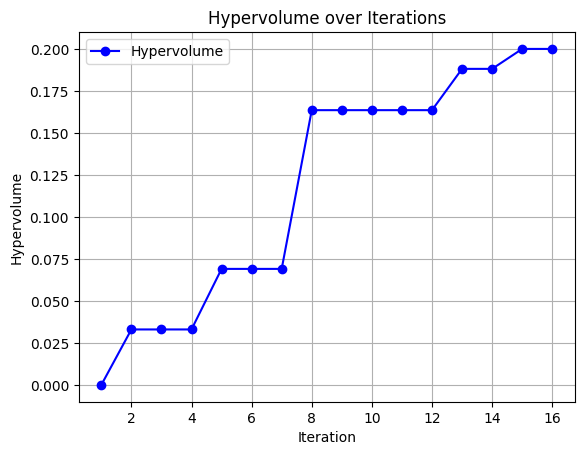

In [27]:
# Plot the hypervolume trace
plt.plot(range(1, len(hypervolume_trace) + 1), hypervolume_trace, label='Hypervolume', marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Hypervolume')
plt.title('Hypervolume over Iterations')
plt.grid(True)
plt.legend()
plt.show()

### More plotting - https://ax.dev/tutorials/visualizations.html

In [28]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.contour import interact_contour
from ax.plot.scatter import (
    interact_fitted,
    plot_objective_vs_constraints,
    tile_fitted,
)
from ax.plot.slice import plot_slice

In [24]:
# Contour or slice plots need RANGE parameters (not Choice)
# CAN'T plot optimization trace as it needs a single objective
# Also plot Model performance/Objective improvement vs # of iterations

### Cross validation

CV plots are useful to check how well the model predictions calibrate against the actual measurements. **If all points are close to the dashed line, then the model is a good predictor of the real data.**

Basically, CV plots show objective plateau, should take >=30-sth trials to optimize (this is for GPEI but might be similar).

The best way to get prediction accuracy of a botorch model is via cross validation.

With folds specified as -1 (the default) we preform leave-one-out cross validation, where we predict once for each observation, using all other observations as a training set and using the selected observation as a single-item test set. 

In [29]:
model = ax_client.generation_strategy.model
cv_results = cross_validate(model, folds= -1) # default folds
render(interact_cross_validation(cv_results))

If we want to understand how the model fit improves over time you may do this after every trial, or use **cross_validate_by_trial(model: ModelBridge, trial: int)** to get the cross validation for all trials up to the trial index specified.

- This seems to only show a single point though? 

In [30]:
from ax.modelbridge.cross_validation import cross_validate_by_trial

model = ax_client.generation_strategy.model
cv_results_by_trial = cross_validate_by_trial(model, trial = 15)
render(interact_cross_validation(cv_results_by_trial))

Etc.

#### Contour plot

Shows the response surface.

The other parameters are fixed in the MIDDLE of their respective ranges.

Interactive contour plots, switching between different parameter combinations.

In [31]:
render(interact_contour(model, metric_name="overpotential"))

- Contour Lines: The contour lines on the plot represent constant values of the response variable (the objective or outcome you're interested in). Each contour line corresponds to a specific value of the response variable.

- Contour Line Patterns: The contour lines may be closer together or farther apart. When contour lines are close together, it indicates that a small change in the input parameters leads to a significant change in the response variable. When contour lines are widely spaced, it suggests that changes in the input parameters have a relatively small impact on the response variable.

- Optimal Regions: In optimization, you're often interested in finding regions on the contour plot where the response variable is either maximized or minimized. These regions correspond to the areas where the contour lines are closest to the desired optimum value.

- Sensitivity Analysis: Contour plots can also be used for sensitivity analysis. You can observe how changes in the input parameters affect the response variable by examining how the contour lines shift or change shape when parameters are adjusted.

#### Tradeoff plot == Pareto frontier for 2 objectives, or how one changes when the other does

Plot the tradeoff between an objective and all other metrics in a model. Here we only have two, so basically the Pareto front.

In [32]:
render(plot_objective_vs_constraints(model, "overpotential", rel=False)) # rel = False

#### Slice plot

Slice plots show the metric outcome as a function of one parameter while fixing the others. They serve a similar function as contour plots.

slice_values: A dictionary {name: val} for the fixed values of the
        other parameters. If not provided, then the status quo values will be used if there is a status quo, otherwise the mean of numeric parameters or the mode of choice parameters. Ignored if fixed_features is specified.

In [35]:
render(plot_slice(model, "pH", "overpotential"))

#### Tile plot

Tile plots are useful for viewing the effect of each arm.

In [36]:
render(interact_fitted(model, rel=False))

## More visualizations

- Different batches corresponding to different colors.

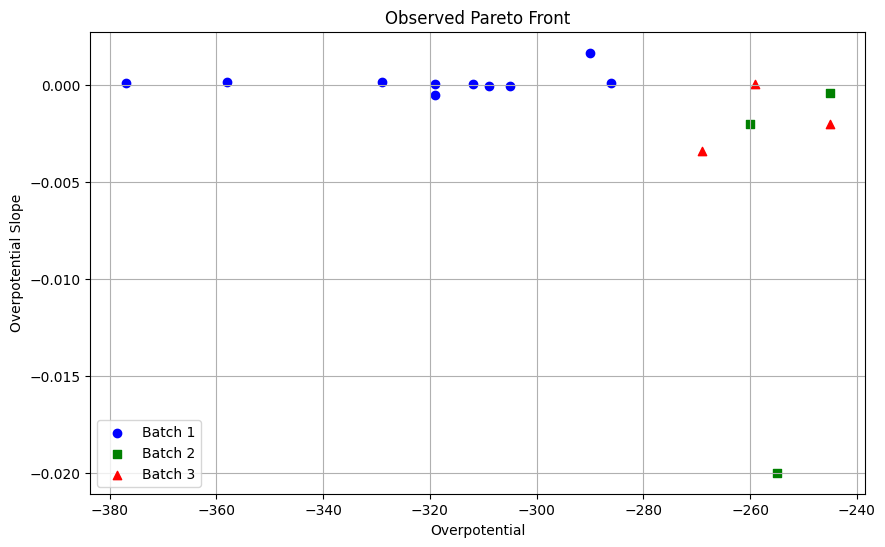

In [45]:
import matplotlib.pyplot as plt

# my data points, organized by batch
data = [
    # Batch 1
    [-358.0, 0.00015],
    [-319.0, 6.6e-05],
    [-377.0, 0.0001],
    [-319.0, -0.000518],
    [-286.0, 8e-05],
    [-312.0, 2.9e-05],
    [-309.0, -5.7e-05],
    [-290.0, 0.001656],
    [-329.0, 0.000131],
    [-305.0, -6.4e-05],
    
    # Batch 2
    [-260.0, -0.002],
    [-255.0, -0.02],
    [-245.0, -0.0004],
    
    # Batch 3
    [-245.0, -0.002],
    [-259.0, 0.00004],
    [-269.0, -0.0034],
]

# Extracting data for each batch
batch_1 = data[:10]
batch_2 = data[10:13]
batch_3 = data[13:]

# Create a scatter plot with different colors for each batch
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*batch_1), label='Batch 1', marker='o', color='b')
plt.scatter(*zip(*batch_2), label='Batch 2', marker='s', color='g')
plt.scatter(*zip(*batch_3), label='Batch 3', marker='^', color='r')

# Labeling and legend
plt.xlabel('Overpotential')
plt.ylabel('Overpotential Slope')
plt.title('Observed Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

- Plot the collected observations where the color corresponds to the trial at which the point was collected.

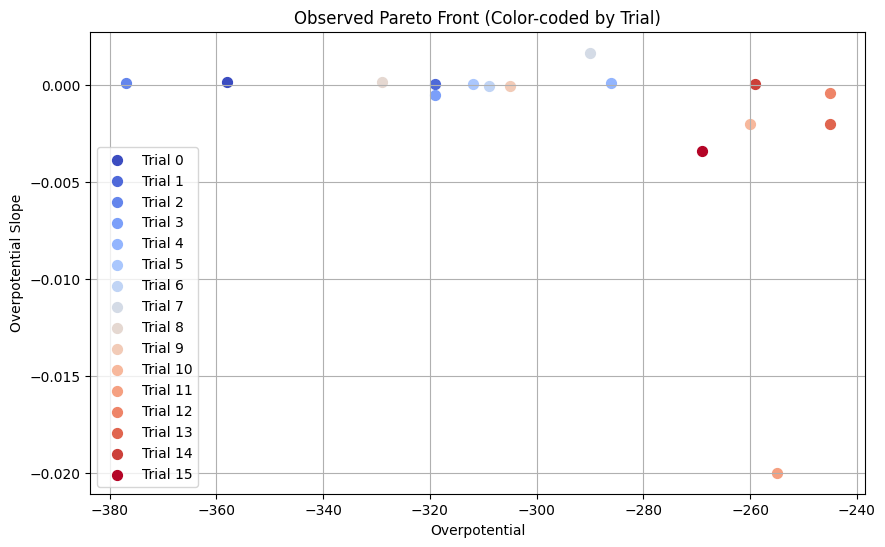

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Your data points, organized by trial
data = [
    # Trial 0-9
    [-358.0, 0.00015],
    [-319.0, 6.6e-05],
    [-377.0, 0.0001],
    [-319.0, -0.000518],
    [-286.0, 8e-05],
    [-312.0, 2.9e-05],
    [-309.0, -5.7e-05],
    [-290.0, 0.001656],
    [-329.0, 0.000131],
    [-305.0, -6.4e-05],
    
    # Trial 10-12
    [-260.0, -0.002],
    [-255.0, -0.02],
    [-245.0, -0.0004],
    
    # Trial 13-15
    [-245.0, -0.002],
    [-259.0, 0.00004],
    [-269.0, -0.0034],
]

# Extracting data for each trial
trials = list(range(len(data)))

# Create a colormap ranging from yellow (worst) to blue (best)
colormap = plt.cm.get_cmap('coolwarm', len(trials))

# Create a scatter plot with points color-coded by trial
plt.figure(figsize=(10, 6))
for i, (overpotential, slope) in enumerate(data):
    color = colormap(i)  # Get color based on trial
    plt.scatter(overpotential, slope, label=f'Trial {i}', color=color, marker='o', s=50)

# Labeling and legend
plt.xlabel('Overpotential')
plt.ylabel('Overpotential Slope')
plt.title('Observed Pareto Front (Color-coded by Trial)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


- Plot the collected observations where the color corresponds to the iteration at which the point was collected.

C:\Users\lordm\AppData\Local\Temp\ipykernel_23360\3154641738.py:52: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



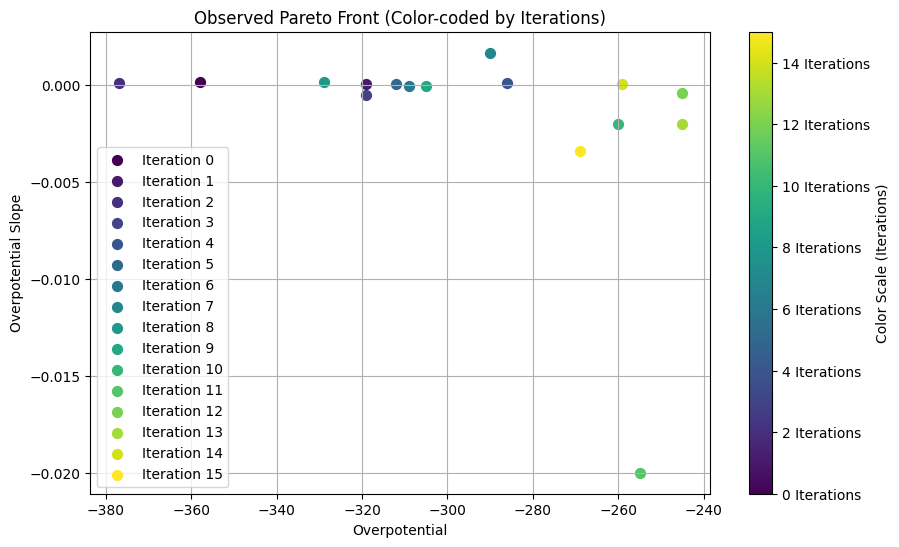

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Your data points, organized by trial
data = [
    # Trial 0-9
    [-358.0, 0.00015],
    [-319.0, 6.6e-05],
    [-377.0, 0.0001],
    [-319.0, -0.000518],
    [-286.0, 8e-05],
    [-312.0, 2.9e-05],
    [-309.0, -5.7e-05],
    [-290.0, 0.001656],
    [-329.0, 0.000131],
    [-305.0, -6.4e-05],
    
    # Trial 10-12
    [-260.0, -0.002],
    [-255.0, -0.02],
    [-245.0, -0.0004],
    
    # Trial 13-15
    [-245.0, -0.002],
    [-259.0, 0.00004],
    [-269.0, -0.0034],
]

# Extracting data for each trial
trials = list(range(len(data)))

# Extract overpotential and overpotential_slope for coloring
overpotential, slope = zip(*data)

# Use the viridis colormap for coloring points
cmap = plt.get_cmap('viridis')

# Normalize the data values for color mapping based on the iteration number
norm = Normalize(vmin=min(trials), vmax=max(trials))

# Create a scatter plot with points color-coded by iteration
plt.figure(figsize=(10, 6))
for i, (op, sl) in enumerate(data):
    color = cmap(norm(i))  # Get color based on the iteration number
    plt.scatter(op, sl, label=f'Iteration {i}', color=color, marker='o', s=50)

# Create a colorbar on the right side of the plot
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, format='%d Iterations')
cbar.set_label('Color Scale (Iterations)')

# Labeling and legend
plt.xlabel('Overpotential')
plt.ylabel('Overpotential Slope')
plt.title('Observed Pareto Front (Color-coded by Iterations)')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()


- Plot the collected observations where the color corresponds to the overpotential value at which the point was collected.

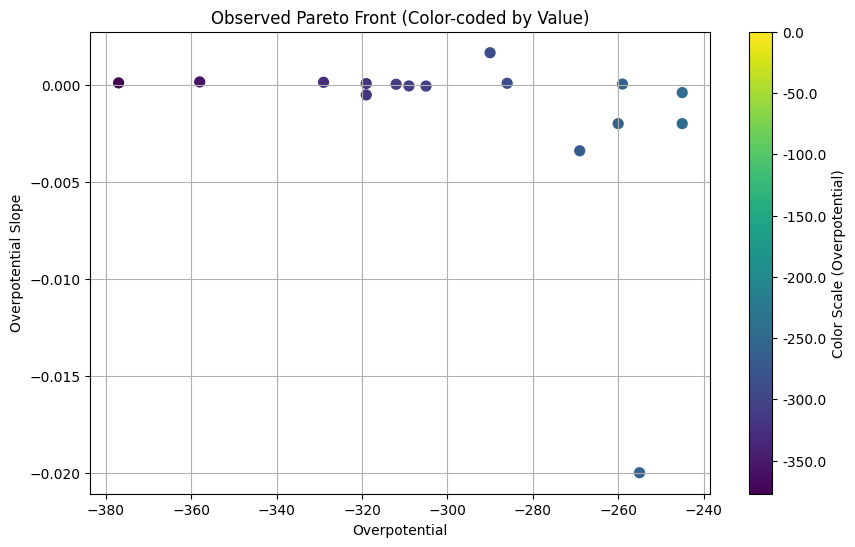

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Your data points, organized by trial
data = [
    # Trial 0-9
    [-358.0, 0.00015],
    [-319.0, 6.6e-05],
    [-377.0, 0.0001],
    [-319.0, -0.000518],
    [-286.0, 8e-05],
    [-312.0, 2.9e-05],
    [-309.0, -5.7e-05],
    [-290.0, 0.001656],
    [-329.0, 0.000131],
    [-305.0, -6.4e-05],
    
    # Trial 10-12
    [-260.0, -0.002],
    [-255.0, -0.02],
    [-245.0, -0.0004],
    
    # Trial 13-15
    [-245.0, -0.002],
    [-259.0, 0.00004],
    [-269.0, -0.0034],
]

# Extracting data for each trial
trials = list(range(len(data)))

# Extract overpotential and overpotential_slope for coloring
overpotential, slope = zip(*data)

# Use the viridis colormap for coloring points
cmap = plt.get_cmap('viridis')

# Normalize the data values for color mapping
norm = Normalize(vmin=min(overpotential + slope), vmax=max(overpotential + slope))

# Create a scatter plot with points color-coded by values
plt.figure(figsize=(10, 6))
sc = plt.scatter(overpotential, slope, c=overpotential, cmap=cmap, norm=norm, marker='o', s=50)

# Create a colorbar on the right side of the plot
cbar = plt.colorbar(sc, format='%.1f')
cbar.set_label('Color Scale (Overpotential)')

# Labeling and legend
plt.xlabel('Overpotential')
plt.ylabel('Overpotential Slope')
plt.title('Observed Pareto Front (Color-coded by Value)')

# Show the plot
plt.grid(True)
plt.show()

- Plot the collected observations where the color corresponds to the overpotential slope value at which the point was collected. 
- Notice the different v_min and v_max of the color map.

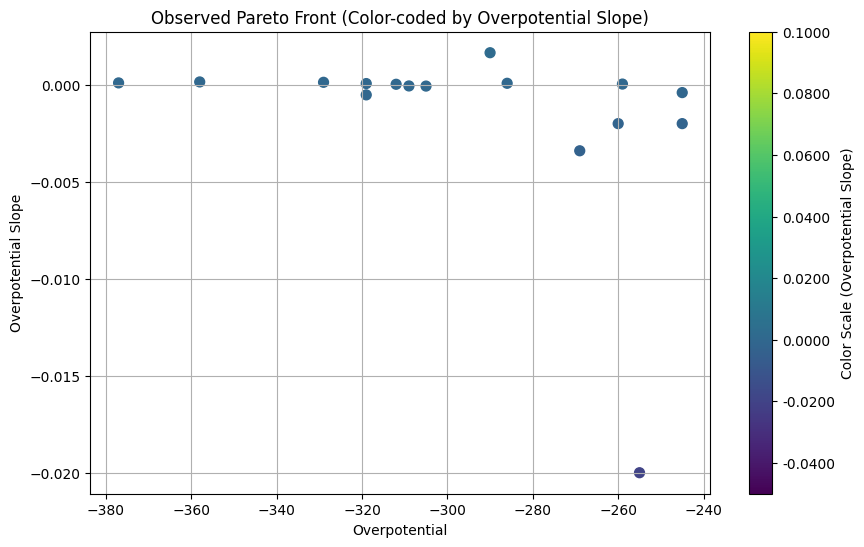

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Your data points, organized by trial
data = [
    # Trial 0-9
    [-358.0, 0.00015],
    [-319.0, 6.6e-05],
    [-377.0, 0.0001],
    [-319.0, -0.000518],
    [-286.0, 8e-05],
    [-312.0, 2.9e-05],
    [-309.0, -5.7e-05],
    [-290.0, 0.001656],
    [-329.0, 0.000131],
    [-305.0, -6.4e-05],
    
    # Trial 10-12
    [-260.0, -0.002],
    [-255.0, -0.02],
    [-245.0, -0.0004],
    
    # Trial 13-15
    [-245.0, -0.002],
    [-259.0, 0.00004],
    [-269.0, -0.0034],
]

# Extracting data for each trial
trials = list(range(len(data)))

# Extract overpotential and overpotential_slope for coloring
overpotential, slope = zip(*data)

# Use the viridis colormap for coloring points
cmap = plt.get_cmap('viridis')

# Normalize the data values for color mapping (scale between -0.2 and 0)
norm = Normalize(vmin=-0.05, vmax=+0.1)

# Create a scatter plot with points color-coded by values
plt.figure(figsize=(10, 6))
sc = plt.scatter(overpotential, slope, c=slope, cmap=cmap, norm=norm, marker='o', s=50)

# Create a colorbar on the right side of the plot
cbar = plt.colorbar(sc, format='%.4f')
cbar.set_label('Color Scale (Overpotential Slope)')

# Labeling and legend
plt.xlabel('Overpotential')
plt.ylabel('Overpotential Slope')
plt.title('Observed Pareto Front (Color-coded by Overpotential Slope)')

# Show the plot
plt.grid(True)
plt.show()
